<a href="https://colab.research.google.com/github/ANS1514/Projects_in_AI-ML/blob/main/ASL_Detection_Real_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import ast
import time
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim, torch.nn.functional as F
import torchvision.models
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn, torchvision.models as tv
import ast
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!nvidia-smi

Mon Apr 21 11:17:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             51W /  400W |   33267MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directories = ["/content/drive/MyDrive/asl_dataset", "/content/drive/MyDrive/asl_alphabet_large"]
data = []
for path in directories:
    for entry in os.scandir(path):
        if not entry.is_dir():
            continue
        label = entry.name.lower()
        for img in os.scandir(entry.path):
            if img.name.lower().endswith((".jpg", ".jpeg")):
                data.append({"image": img.path, "label": label})

print(f"Found {len(data)} images across {len({d['label'] for d in data})} labels.")

Found 89522 images across 39 labels.


In [ ]:
saved_df = pd.read_parquet('/content/drive/MyDrive/aslData.csv')
df = pd.DataFrame(data)
image_df = pd.DataFrame(data)

In [ ]:
print(image_df.head)

<bound method NDFrame.head of                                                    image label
0      /content/drive/MyDrive/asl_dataset/y/hand1_y_d...     y
1      /content/drive/MyDrive/asl_dataset/y/hand1_y_b...     y
2      /content/drive/MyDrive/asl_dataset/y/hand1_y_d...     y
3      /content/drive/MyDrive/asl_dataset/y/hand1_y_b...     y
4      /content/drive/MyDrive/asl_dataset/y/hand1_y_l...     y
...                                                  ...   ...
89517  /content/drive/MyDrive/asl_alphabet_large/G/G1...     g
89518  /content/drive/MyDrive/asl_alphabet_large/G/G1...     g
89519  /content/drive/MyDrive/asl_alphabet_large/G/G1...     g
89520  /content/drive/MyDrive/asl_alphabet_large/G/G1...     g
89521  /content/drive/MyDrive/asl_alphabet_large/G/G1...     g

[89522 rows x 2 columns]>


In [ ]:
!pip install mediapipe
import mediapipe as mp
import threading
from concurrent.futures import ThreadPoolExecutor

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [ ]:
# threaded processing of hand keypoint data to decrease the runtime
thread_local = threading.local()

def get_hands():
    if not hasattr(thread_local, "hands"):
        thread_local.hands = mp.solutions.hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.7
        )
    return thread_local.hands

def process_one(args):
    img_path, label = args
    img = cv2.imread(img_path)
    if img is None:
        return None

    h, w = img.shape[:2]
    small = cv2.resize(img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)

    results = get_hands().process(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
    if not results.multi_hand_landmarks:
        return None

    kp = np.array([
        [lm.x, lm.y, lm.z]
        for lm in results.multi_hand_landmarks[0].landmark
    ]).flatten()
    return {"keypoints": kp, "label": label}

args = list(zip(df['image'], df['label']))
records = []

with ThreadPoolExecutor(max_workers=10) as exe:
    for rec in tqdm(exe.map(process_one, args), total=len(args),
                    desc="extracting keypoints"):
        if rec:
            records.append(rec)

In [ ]:
# Intial checking of the data and saving of the dataframe to avoid finding the keypoints again
augmented_df = pd.DataFrame(records)
augmented_df.head()

In [ ]:
augmented_df = saved_df

In [ ]:
augmented_df.to_parquet('/content/drive/MyDrive/aslData.csv')

In [ ]:
# Mirror the hand data in order to fix the bias of handedness
def mirror_keypoints(kp: np.ndarray) -> np.ndarray:
    kp_mirrored = kp.copy()
    kp_mirrored[0::3] = 1.0 - kp_mirrored[0::3]
    return kp_mirrored

df_mirror = df.copy()
df_mirror["keypoints"] = df_mirror["keypoints"].apply(mirror_keypoints)

df_augmented = pd.concat([df, df_mirror], ignore_index=True)
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset size grew from {len(df)} → {len(df_augmented)}")

Dataset size grew from 62185 → 124370


In [ ]:
# Check the label sizes to detect and class imbalances
print(augmented_df['label'].value_counts())
df = augmented_df.copy()

label
f          2797
k          2659
y          2610
v          2597
j          2581
u          2510
w          2492
d          2476
r          2473
l          2473
s          2469
h          2413
t          2374
i          2329
z          2326
x          2296
g          2276
e          2173
o          2106
q          2052
p          2043
a          1973
b          1940
c          1780
space      1668
del        1545
m          1122
n           996
3            70
9            70
5            70
8            69
4            68
1            67
7            65
2            64
6            60
0            27
nothing       6
Name: count, dtype: int64


In [ ]:
# keep only labels that are a single character a–z for both the image dataset and keypoint dataset
df_augmented = df_augmented[df_augmented['label'].str.match(r'^[a-z]$')]
print(df_augmented['label'].value_counts())

image_df = image_df[image_df['label'].str.match(r'^[a-z]$')]
print(image_df['label'].value_counts())

label
f    5594
k    5318
y    5220
v    5194
j    5162
u    5020
w    4984
d    4952
r    4946
l    4946
s    4938
h    4826
t    4748
i    4658
z    4652
x    4592
g    4552
e    4346
o    4212
q    4104
p    4086
a    3946
b    3880
c    3560
m    2244
n    1992
Name: count, dtype: int64
label
z    3077
y    3070
x    3070
u    3070
w    3070
v    3070
r    3070
q    3070
s    3070
p    3070
i    3070
n    3070
o    3070
m    3070
l    3070
h    3070
j    3070
k    3070
d    3070
g    3070
f    3070
e    3070
b    3070
c    3070
a    3070
t    3065
Name: count, dtype: int64


In [ ]:
# Dataset classes for easy implementation of models
class HandImageDataset(Dataset):
    def __init__(self, df, img_col='image', label='label', label_col='label_id', img_size=224):
        self.df       = df.reset_index(drop=True)
        self.img_col  = img_col
        self.label = label
        self.label_col= label_col
        self.tf = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row[self.img_col]).convert('RGB')
        img = self.tf(img)
        lbl = torch.tensor(row[self.label_col], dtype=torch.long)
        return img, lbl

class HandKeypointDataset(Dataset):
    def __init__(self, df, kp_col='keypoints', label_col='label_id'):
        self.kps    = df[kp_col].tolist()
        self.labels = df[label_col].astype('int64').tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        kp_seq = torch.tensor(self.kps[idx], dtype=torch.float32).unsqueeze(0)
        lbl    = torch.tensor(self.labels[idx], dtype=torch.long)
        return kp_seq, lbl

In [ ]:
# CNN classifiers for images data
class ResnetImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = tv.resnet18(weights=tv.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*(list(resnet.children())[:-1]))
        self.head     = nn.Linear(512, n_classes)

    def forward(self, img, kp=None):
        x = self.backbone(img)
        x = x.view(x.size(0), -1)
        return self.head(x)

class AlexNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # load pretrained AlexNet
        model = tv.alexnet(weights=tv.AlexNet_Weights.IMAGENET1K_V1)
        # replace final classifier layer
        in_feats = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_feats, num_classes)
        self.net = model
    def forward(self, x):
        return self.net(x)

# LSTM for keypoint detection (1 frame)
class KeypointLSTM(nn.Module):
    def __init__(self, dim=63, hidden=128, layers=2, n_classes=36):
        super().__init__()
        self.lstm = nn.LSTM(dim, hidden, num_layers=layers,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden*2, n_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        feat   = out.mean(1)
        return self.classifier(feat)

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    matthews_corrcoef, log_loss, roc_auc_score,
)

In [ ]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct = 0.0, 0
    with torch.set_grad_enabled(train):
        for kps, labels in tqdm(loader, leave=False):
            kps, labels = kps.to(device), labels.to(device)
            if train: optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                logits = model(kps)
                loss   = F.cross_entropy(logits, labels)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            total_loss += loss.item()*labels.size(0)
            correct    += (logits.argmax(1)==labels).sum().item()
    avg_loss = total_loss/len(loader.dataset)
    acc      = correct/len(loader.dataset)
    return avg_loss, acc

def eval_epoch(loader):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
        for kps, lbl in loader:
            kps  = kps.to(device)
            prob = F.softmax(model(kps), dim=1).cpu().numpy()
            y_prob.append(prob)
            y_true.append(lbl.numpy())

    y_prob = np.concatenate(y_prob)
    y_true = np.concatenate(y_true)
    y_pred = y_prob.argmax(1)


    metrics = {
        "loss"            : log_loss(y_true, y_prob),
        "acc"             : (y_pred == y_true).mean(),
        "mcc"             : matthews_corrcoef    (y_true, y_pred),
        "roc_auc_macro"   : roc_auc_score(
                                np.eye(y_prob.shape[1])[y_true],
                                y_prob, average="macro",
                                multi_class="ovr"),
    }
    return metrics

In [ ]:
df_augmented['label_id'] = df_augmented['label'].astype('category').cat.codes.astype('int64')
image_df['label_id'] = image_df['label'].astype('category').cat.codes.astype('int64')
NUM_CLASSES = df_augmented['label_id'].nunique()
BATCH_SIZE = 2048
EPOCHS = 100

kp_train_df, kp_test_df = train_test_split(
    df_augmented,
    test_size=0.10,
    stratify=df_augmented['label_id'],
    random_state=42
)


img_train_df, img_test_df = train_test_split(
    image_df,
    test_size=0.10,
    stratify=image_df['label_id'],
    random_state=42
)

kp_train_ds = HandKeypointDataset(kp_train_df)
kp_test_ds  = HandKeypointDataset(kp_test_df)
kp_train_loader = DataLoader(kp_train_ds, BATCH_SIZE, shuffle=True,
                             num_workers=10, pin_memory=torch.cuda.is_available())
kp_test_loader  = DataLoader(kp_test_ds,  BATCH_SIZE, shuffle=False,
                             num_workers=10, pin_memory=torch.cuda.is_available())

img_train_ds = HandImageDataset(img_train_df)
img_test_ds  = HandImageDataset(img_test_df)
img_train_loader = DataLoader(img_train_ds, BATCH_SIZE, shuffle=True,
                              num_workers=4)
img_test_loader  = DataLoader(img_test_ds, BATCH_SIZE, shuffle=False,
                              num_workers=4)

In [ ]:
MODELS = {
    "resnet18": lambda n: ResnetImageClassifier(n),
    "alexnet" : lambda n: AlexNetClassifier(n),
    "lstm" : lambda n: KeypointLSTM(dim=63, n_classes=n),
}
results  = {}
histories = {}

for name, make_model in MODELS.items():
    if name == "lstm":
        train_loader, test_loader = kp_train_loader, kp_test_loader
    else:
        train_loader, test_loader = img_train_loader, img_test_loader

    model = make_model(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    scaler    = torch.amp.GradScaler()

    best_acc   = 0.0
    best_state = None

    history = defaultdict(list)

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc  = run_epoch(train_loader, train=True)
        te_metrics       = eval_epoch(test_loader)
        scheduler.step(te_metrics["loss"])

        # track performance
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc" ].append(tr_acc)
        for k, v in te_metrics.items():
            history[f"test_{k}"].append(v)

        tqdm.write(f"[{name}][{epoch:03}] "
                   f"train‑loss {tr_loss:.4f} acc {tr_acc:.3f} | "
                   f"test‑loss {te_metrics['loss']:.4f} acc {te_metrics['acc']:.3f}")

        # keep best
        if te_metrics["acc"] > best_acc:
            best_acc   = te_metrics["acc"]
            best_state = {
                "model_state": model.state_dict(),
                "optimizer"  : optimizer.state_dict(),
                "epoch"      : epoch,
                "metrics"    : te_metrics,
            }

        scheduler.step(te_metrics['loss'])

    results[name] = {
        "accuracy"        : history["test_acc"][-1],
        "log_loss"        : history["test_loss"][-1],
        "mcc"             : history["test_mcc"][-1],
        "roc_auc_macro"   : history["test_roc_auc_macro"][-1],
    }
    # save best model for easy real time implementation later
    ckpt_path = os.path.join('/content/drive/MyDrive/ASL_models', f"{name}_best.pth")
    torch.save(best_state, ckpt_path)
    print(f"Saved {name} best model")

    histories[name] = history
    del model; torch.cuda.empty_cache()

import pandas as pd
pd.DataFrame(results).T.to_csv("model_results.csv")
print("\nSaved final metrics to model_results.csv")

[lstm][001] train‑loss 3.2411 acc 0.052 | test‑loss 3.2218 acc 0.112


[lstm][002] train‑loss 3.1451 acc 0.123 | test‑loss 2.9449 acc 0.178


[lstm][003] train‑loss 2.5548 acc 0.305 | test‑loss 2.1784 acc 0.408


[lstm][004] train‑loss 1.9506 acc 0.475 | test‑loss 1.7459 acc 0.538


[lstm][005] train‑loss 1.6203 acc 0.582 | test‑loss 1.4969 acc 0.592


[lstm][006] train‑loss 1.4109 acc 0.643 | test‑loss 1.3144 acc 0.690


[lstm][007] train‑loss 1.2493 acc 0.702 | test‑loss 1.1684 acc 0.724


[lstm][008] train‑loss 1.1218 acc 0.743 | test‑loss 1.0563 acc 0.760


[lstm][009] train‑loss 1.0233 acc 0.772 | test‑loss 0.9711 acc 0.784


[lstm][010] train‑loss 0.9464 acc 0.791 | test‑loss 0.9061 acc 0.801


[lstm][011] train‑loss 0.8827 acc 0.804 | test‑loss 0.8446 acc 0.812


[lstm][012] train‑loss 0.8296 acc 0.813 | test‑loss 0.7952 acc 0.822


[lstm][013] train‑loss 0.7845 acc 0.821 | test‑loss 0.7540 acc 0.828


[lstm][014] train‑loss 0.7442 acc 0.828 | test‑loss 0.7170 acc 0.834


[lstm][015] train‑loss 0.7083 acc 0.835 | test‑loss 0.6816 acc 0.842


[lstm][016] train‑loss 0.6762 acc 0.840 | test‑loss 0.6540 acc 0.845


[lstm][017] train‑loss 0.6471 acc 0.845 | test‑loss 0.6306 acc 0.848


[lstm][018] train‑loss 0.6218 acc 0.849 | test‑loss 0.5996 acc 0.856


[lstm][019] train‑loss 0.5984 acc 0.853 | test‑loss 0.5787 acc 0.858


[lstm][020] train‑loss 0.5767 acc 0.857 | test‑loss 0.5583 acc 0.862


[lstm][021] train‑loss 0.5572 acc 0.861 | test‑loss 0.5416 acc 0.863


[lstm][022] train‑loss 0.5406 acc 0.863 | test‑loss 0.5229 acc 0.866


[lstm][023] train‑loss 0.5225 acc 0.867 | test‑loss 0.5080 acc 0.870


[lstm][024] train‑loss 0.5071 acc 0.871 | test‑loss 0.4913 acc 0.872


[lstm][025] train‑loss 0.4930 acc 0.873 | test‑loss 0.4790 acc 0.875


[lstm][026] train‑loss 0.4799 acc 0.874 | test‑loss 0.4643 acc 0.877


[lstm][027] train‑loss 0.4671 acc 0.877 | test‑loss 0.4535 acc 0.879


[lstm][028] train‑loss 0.4555 acc 0.879 | test‑loss 0.4421 acc 0.881


[lstm][029] train‑loss 0.4451 acc 0.881 | test‑loss 0.4315 acc 0.883


[lstm][030] train‑loss 0.4353 acc 0.882 | test‑loss 0.4221 acc 0.885


[lstm][031] train‑loss 0.4252 acc 0.884 | test‑loss 0.4170 acc 0.884


[lstm][032] train‑loss 0.4169 acc 0.885 | test‑loss 0.4064 acc 0.886


[lstm][033] train‑loss 0.4087 acc 0.887 | test‑loss 0.3970 acc 0.889


[lstm][034] train‑loss 0.4000 acc 0.889 | test‑loss 0.3900 acc 0.890


[lstm][035] train‑loss 0.3931 acc 0.890 | test‑loss 0.3829 acc 0.892


[lstm][036] train‑loss 0.3868 acc 0.891 | test‑loss 0.3766 acc 0.892


[lstm][037] train‑loss 0.3795 acc 0.893 | test‑loss 0.3711 acc 0.894


[lstm][038] train‑loss 0.3737 acc 0.894 | test‑loss 0.3668 acc 0.895


[lstm][039] train‑loss 0.3675 acc 0.895 | test‑loss 0.3594 acc 0.894


[lstm][040] train‑loss 0.3623 acc 0.896 | test‑loss 0.3573 acc 0.894


[lstm][041] train‑loss 0.3562 acc 0.898 | test‑loss 0.3484 acc 0.897


[lstm][042] train‑loss 0.3508 acc 0.899 | test‑loss 0.3445 acc 0.900


[lstm][043] train‑loss 0.3463 acc 0.900 | test‑loss 0.3413 acc 0.900


[lstm][044] train‑loss 0.3414 acc 0.901 | test‑loss 0.3370 acc 0.900


[lstm][045] train‑loss 0.3379 acc 0.901 | test‑loss 0.3313 acc 0.903


[lstm][046] train‑loss 0.3343 acc 0.902 | test‑loss 0.3303 acc 0.901


[lstm][047] train‑loss 0.3283 acc 0.904 | test‑loss 0.3223 acc 0.905


[lstm][048] train‑loss 0.3233 acc 0.905 | test‑loss 0.3191 acc 0.905


[lstm][049] train‑loss 0.3198 acc 0.906 | test‑loss 0.3157 acc 0.906


[lstm][050] train‑loss 0.3157 acc 0.907 | test‑loss 0.3114 acc 0.906


[lstm][051] train‑loss 0.3140 acc 0.907 | test‑loss 0.3131 acc 0.905


[lstm][052] train‑loss 0.3085 acc 0.908 | test‑loss 0.3083 acc 0.906


[lstm][053] train‑loss 0.3065 acc 0.909 | test‑loss 0.3015 acc 0.909


[lstm][054] train‑loss 0.3014 acc 0.911 | test‑loss 0.3095 acc 0.906


[lstm][055] train‑loss 0.2997 acc 0.910 | test‑loss 0.2957 acc 0.911


[lstm][056] train‑loss 0.2943 acc 0.913 | test‑loss 0.2942 acc 0.911


[lstm][057] train‑loss 0.2911 acc 0.913 | test‑loss 0.2904 acc 0.912


[lstm][058] train‑loss 0.2890 acc 0.914 | test‑loss 0.2869 acc 0.913


[lstm][059] train‑loss 0.2846 acc 0.915 | test‑loss 0.2845 acc 0.913


[lstm][060] train‑loss 0.2817 acc 0.915 | test‑loss 0.2813 acc 0.914


[lstm][061] train‑loss 0.2787 acc 0.916 | test‑loss 0.2800 acc 0.913


[lstm][062] train‑loss 0.2763 acc 0.917 | test‑loss 0.2770 acc 0.914


[lstm][063] train‑loss 0.2726 acc 0.918 | test‑loss 0.2737 acc 0.916


[lstm][064] train‑loss 0.2720 acc 0.918 | test‑loss 0.2729 acc 0.915


[lstm][065] train‑loss 0.2692 acc 0.919 | test‑loss 0.2681 acc 0.919


[lstm][066] train‑loss 0.2650 acc 0.920 | test‑loss 0.2675 acc 0.917


[lstm][067] train‑loss 0.2624 acc 0.920 | test‑loss 0.2653 acc 0.917


[lstm][068] train‑loss 0.2595 acc 0.921 | test‑loss 0.2615 acc 0.918


[lstm][069] train‑loss 0.2579 acc 0.921 | test‑loss 0.2611 acc 0.919


[lstm][070] train‑loss 0.2553 acc 0.922 | test‑loss 0.2589 acc 0.919


[lstm][071] train‑loss 0.2529 acc 0.923 | test‑loss 0.2569 acc 0.919


[lstm][072] train‑loss 0.2504 acc 0.923 | test‑loss 0.2538 acc 0.921


[lstm][073] train‑loss 0.2483 acc 0.924 | test‑loss 0.2513 acc 0.921


[lstm][074] train‑loss 0.2451 acc 0.925 | test‑loss 0.2493 acc 0.920


[lstm][075] train‑loss 0.2435 acc 0.925 | test‑loss 0.2470 acc 0.923


[lstm][076] train‑loss 0.2409 acc 0.926 | test‑loss 0.2453 acc 0.922


[lstm][077] train‑loss 0.2385 acc 0.927 | test‑loss 0.2425 acc 0.923


[lstm][078] train‑loss 0.2360 acc 0.928 | test‑loss 0.2414 acc 0.925


[lstm][079] train‑loss 0.2350 acc 0.928 | test‑loss 0.2411 acc 0.924


[lstm][080] train‑loss 0.2348 acc 0.928 | test‑loss 0.2369 acc 0.926


[lstm][081] train‑loss 0.2302 acc 0.930 | test‑loss 0.2340 acc 0.927


[lstm][082] train‑loss 0.2282 acc 0.931 | test‑loss 0.2335 acc 0.927


[lstm][083] train‑loss 0.2261 acc 0.931 | test‑loss 0.2304 acc 0.929


[lstm][084] train‑loss 0.2240 acc 0.932 | test‑loss 0.2303 acc 0.928


[lstm][085] train‑loss 0.2230 acc 0.932 | test‑loss 0.2276 acc 0.931


[lstm][086] train‑loss 0.2200 acc 0.934 | test‑loss 0.2266 acc 0.928


[lstm][087] train‑loss 0.2187 acc 0.934 | test‑loss 0.2233 acc 0.932


[lstm][088] train‑loss 0.2166 acc 0.935 | test‑loss 0.2224 acc 0.932


[lstm][089] train‑loss 0.2149 acc 0.935 | test‑loss 0.2224 acc 0.929


[lstm][090] train‑loss 0.2127 acc 0.936 | test‑loss 0.2196 acc 0.931


[lstm][091] train‑loss 0.2107 acc 0.936 | test‑loss 0.2176 acc 0.933


[lstm][092] train‑loss 0.2088 acc 0.938 | test‑loss 0.2160 acc 0.932


[lstm][093] train‑loss 0.2076 acc 0.937 | test‑loss 0.2154 acc 0.932


[lstm][094] train‑loss 0.2056 acc 0.938 | test‑loss 0.2124 acc 0.935


[lstm][095] train‑loss 0.2037 acc 0.939 | test‑loss 0.2123 acc 0.935


[lstm][096] train‑loss 0.2025 acc 0.939 | test‑loss 0.2103 acc 0.935


[lstm][097] train‑loss 0.2006 acc 0.940 | test‑loss 0.2077 acc 0.935


[lstm][098] train‑loss 0.1985 acc 0.941 | test‑loss 0.2089 acc 0.936


[lstm][099] train‑loss 0.1989 acc 0.939 | test‑loss 0.2046 acc 0.937


[lstm][100] train‑loss 0.1956 acc 0.942 | test‑loss 0.2041 acc 0.935
Saved lstm best model

Saved final metrics to model_results.csv


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train = np.stack(kp_train_df["keypoints"].values).astype(np.float32)
y_train = kp_train_df["label_id"].values
X_test  = np.stack(kp_test_df ["keypoints"].values).astype(np.float32)
y_test  = kp_test_df ["label_id"].values

# Classical models, parameters
models = {
    "GB‑trees": HistGradientBoostingClassifier(
                    learning_rate=0.05,
                    max_iter=100,
                    l2_regularization=0.1,
                    class_weight="balanced"),

    "LogReg": make_pipeline(
                    StandardScaler(),
                    LogisticRegression(
                        multi_class="multinomial",
                        solver="saga",
                        penalty="l2", C=26.0,
                        max_iter=100,
                        class_weight="balanced")),
}
results = {}
for name, clf in tqdm(models.items(), total=len(models),
                      desc="Training & scoring classical models"):
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    results[name] = acc
    tqdm.write(f"{name:10s} accuracy: {acc:.4f}")

Training & scoring classical models:  50%|█████     | 1/2 [01:47<01:47, 107.96s/it]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GB‑trees   accuracy: 0.9829


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training & scoring classical models: 100%|██████████| 2/2 [02:59<00:00, 89.88s/it]

LogReg     accuracy: 0.9158


In [ ]:
# setting numbers to labels for classification
id2label = dict(enumerate(image_df['label'].astype('category').cat.categories))
print(id2label)
print(NUM_CLASSES)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
26



=== GB‑trees ===
Metric summary
 accuracy         0.9829
MCC              0.9822
log‑loss         0.0831
ROC‑AUC macro    0.9999
dtype: float64 

Per‑class precision/recall/F1
        precision  recall  f1-score  support
class                                      
0         0.9899  0.9899    0.9899    395.0
1         0.9821  0.9897    0.9859    388.0
2         0.9972  0.9944    0.9958    356.0
3         0.9840  0.9919    0.9879    495.0
4         0.9931  0.9885    0.9908    435.0
5         0.9964  0.9982    0.9973    560.0
6         0.9934  0.9912    0.9923    455.0
7         0.9917  0.9876    0.9896    483.0
8         0.9787  0.9850    0.9818    466.0
9         0.9961  0.9826    0.9893    516.0
10        0.9830  0.9793    0.9812    532.0
11        0.9939  0.9919    0.9929    495.0
12        0.9509  0.9509    0.9509    224.0
13        0.9695  0.9598    0.9646    199.0
14        0.9835  0.9929    0.9882    421.0
15        0.9951  0.9976    0.9963    409.0
16        0.9927  0.9927    0.

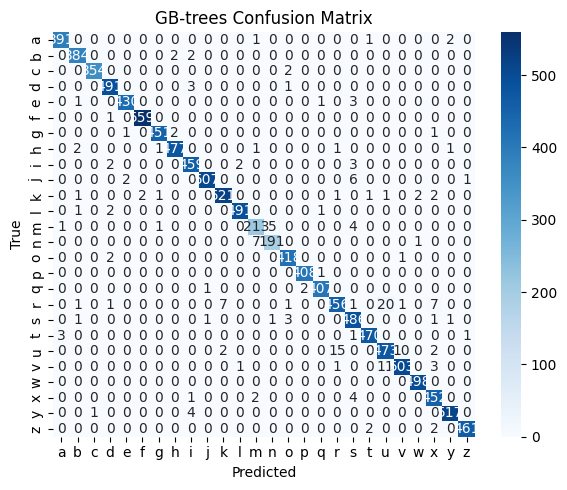


=== LogReg ===
Metric summary
 accuracy         0.9158
MCC              0.9123
log‑loss         0.3746
ROC‑AUC macro    0.9942
dtype: float64 

Per‑class precision/recall/F1
        precision  recall  f1-score  support
class                                      
0         0.9040  0.9772    0.9392    395.0
1         0.9144  0.9639    0.9385    388.0
2         0.9503  0.9663    0.9582    356.0
3         0.9668  0.8828    0.9229    495.0
4         0.9236  0.9448    0.9341    435.0
5         0.9715  0.9732    0.9723    560.0
6         0.9454  0.9516    0.9485    455.0
7         0.9498  0.9400    0.9448    483.0
8         0.9065  0.8948    0.9006    466.0
9         0.9566  0.8973    0.9260    516.0
10        0.9317  0.9229    0.9273    532.0
11        0.9657  0.9677    0.9667    495.0
12        0.7432  0.7366    0.7399    224.0
13        0.7598  0.7789    0.7692    199.0
14        0.9312  0.9644    0.9475    421.0
15        0.9531  0.9438    0.9484    409.0
16        0.9129  0.9463    0.92

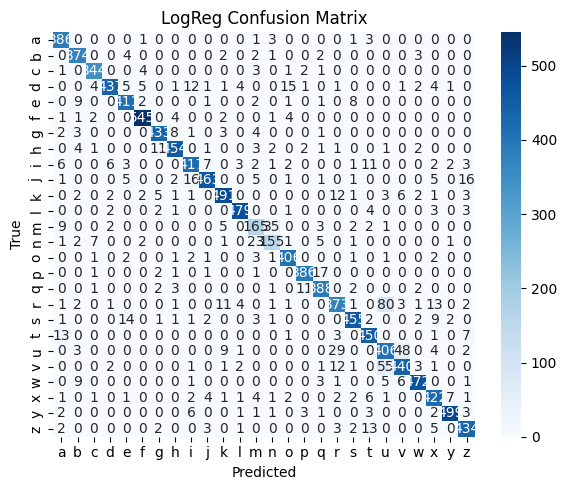

In [ ]:
# testing of the classical models
def evaluate_sklearn_model(name, clf, X_test, y_test, id2label):
    y_prob = clf.predict_proba(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    report = classification_report(
        y_test, y_pred, digits=4, output_dict=True
    )
    metrics = {
        "accuracy"      : report["accuracy"],
        "MCC"           : matthews_corrcoef(y_test, y_pred),
        "log‑loss"      : log_loss       (y_test, y_prob),
        "ROC‑AUC macro": roc_auc_score(
                              np.eye(y_prob.shape[1])[y_test],
                              y_prob,
                              average="macro",
                              multi_class="ovr")
    }
    summary = pd.Series(metrics).round(4)

    print(f"\n=== {name} ===")
    print("Metric summary\n", summary, "\n")
    df_cr = (
        pd.DataFrame(report)
          .T
          .drop(index=["accuracy", "macro avg", "weighted avg"])
          .rename_axis("class")
          .round(4)
    )
    print("Per‑class precision/recall/F1\n", df_cr, "\n")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=id2label.values(),
        yticklabels=id2label.values()
    )
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# run it for each classical model
for name, clf in models.items():
    evaluate_sklearn_model(name, clf, X_test, y_test, id2label)


Metric summary
 overall accuracy    0.9345
MCC                 0.9319
log‑loss            0.2041
macro ROC‑AUC       0.9984
dtype: float64
       precision  recall  f1-score  support
class                                      
0         0.9553  0.9747    0.9649    395.0
1         0.9325  0.9613    0.9467    388.0
2         0.9619  0.9916    0.9765    356.0
3         0.9662  0.9232    0.9442    495.0
4         0.9501  0.9632    0.9566    435.0


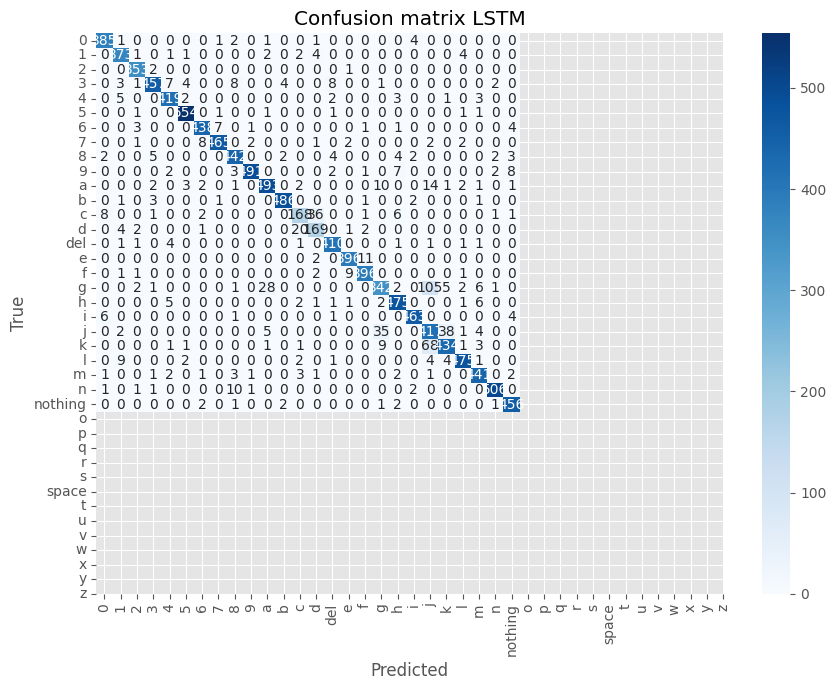

In [ ]:
# Grab the desired model and load it
ckpt_path = "/content/drive/MyDrive/ASL_models/lstm_best.pth"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
model = KeypointLSTM(dim=63, n_classes=NUM_CLASSES).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

y_true, y_pred, y_prob = [], [], []

# evaluate the model
with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
    for kps, lbls in kp_test_loader:
        kps  = kps.to(device)
        logits = model(kps)

        probs  = F.softmax(logits, dim=1).cpu().numpy()
        y_prob.append(probs)
        y_pred.extend(probs.argmax(1))
        y_true.extend(lbls.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

report = classification_report(y_true, y_pred, digits=4, output_dict=True)

metrics = {
    "overall accuracy"  : report["accuracy"],
    "MCC"               : matthews_corrcoef    (y_true, y_pred),
    "log‑loss"          : log_loss             (y_true, y_prob),
    "macro ROC‑AUC"     : roc_auc_score(
                              np.eye(y_prob.shape[1])[y_true],
                              y_prob, average="macro",
                              multi_class="ovr")
}

# show results
summary = pd.Series(metrics).round(4)
print("\nMetric summary\n", summary)

df_cr = (pd.DataFrame(report)
           .T.drop(index=["accuracy", "macro avg", "weighted avg"])
           .rename_axis("class").round(4))
print(df_cr.head())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=id2label.values(), yticklabels=id2label.values())
plt.title("Confusion matrix LSTM")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [ ]:
# setup mediapipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

Button(button_style='danger', description='Stop', style=ButtonStyle())

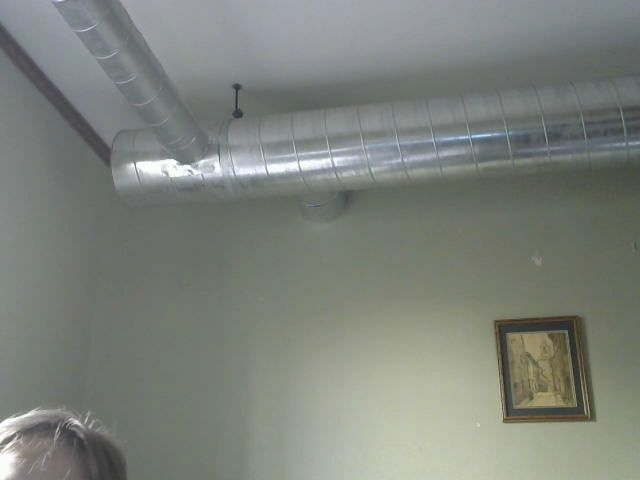

KeyboardInterrupt: 

In [ ]:
# imports for running in real time
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import display, clear_output, Image as IPyImage
import ipywidgets as widgets
from datetime import datetime

# function for finding the frame
def take_frame(quality=0.8):
    js = f'''
    async function capture(q) {{
      const v = document.createElement('video');
      const s = await navigator.mediaDevices.getUserMedia({{video:true}});
      v.srcObject = s;
      await v.play();
      await new Promise(r => setTimeout(r,200));
      const c = document.createElement('canvas');
      c.width = v.videoWidth; c.height = v.videoHeight;
      c.getContext('2d').drawImage(v, 0,0);
      s.getVideoTracks()[0].stop();
      return c.toDataURL('image/jpeg', q);
    }}
    capture({quality})
    '''
    data = eval_js(js)
    img_bytes = b64decode(data.split(',')[1])
    arr = np.frombuffer(img_bytes, dtype=np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_COLOR)

# 3) Transforms & label map
tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
id2label = dict(enumerate(image_df['label'].astype('category').cat.categories))

# Stop button for main loop
stop_flag = { 'stop': False }
button = widgets.Button(description="Stop", button_style='danger')
def on_stop_click(b):
    stop_flag['stop'] = True
button.on_click(on_stop_click)
display(button)

# setup saaving of frames
save_dir = "/content/drive/MyDrive/Captured_signs"
os.makedirs(save_dir, exist_ok=True)

# saving frequency options
frame_counter = 0
save_every = 5

# main loop for real time detections
while not stop_flag['stop']:
    frame = take_frame()
    if frame is None:
        print("Failed to grab frame.")
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        lm = results.multi_hand_landmarks[0].landmark
        for p in lm:
            x,y = int(p.x*frame.shape[1]), int(p.y*frame.shape[0])
            cv2.circle(frame, (x,y), 3, (0,255,0), -1)

        kp   = torch.tensor(np.array([[p.x,p.y,p.z] for p in lm]).flatten(),
                             dtype=torch.float32).to(device)
        kp = kp.unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            logits = model(kp)
            pred = id2label[logits.argmax(dim=1).item()]

        cv2.putText(frame, f"Sign: {pred}", (10,40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        frame_counter += 1

        # Save every frame as defined before
        if frame_counter % save_every == 0:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
            filename = f"{pred}_{timestamp}.jpg"
            filepath = os.path.join(save_dir, filename)
            cv2.imwrite(filepath, frame)
            print(f"Saved: {filepath}")

    clear_output(wait=True)
    display(button)
    _, buf = cv2.imencode('.jpg', frame)
    display(IPyImage(data=buf.tobytes()))

# Cleanup
clear_output()
print("Stopped.")